# **Bird Image Classification with Transfer Learning : MobileNetV2**

<img src="https://images8.alphacoders.com/514/514566.jpg" alt="Girl in a jacket" width="800" height="auto" class="center"/>

---





# **Introduction**


The aim of this project is to classify 8 different species of Parrot with Transfer Learning. Keras pretrained CNN model **MobileNetV2** is used for Transfer Learning. MobileNetV2 model was pre-trained on **ImageNet** dataset containing over 14 million images and 1000 classes.

900 Parrot Species images were gathered from internet where image dimension is at least 160 x 160. Parrot Species for classification are: 

* Blue and Yellow Macaw
* Budgerigar
* Rainbow Lorikeet
* Golden Parakeet
* Hyacinth Macaw
* Spixs Macaw
* Scarlet Macaw
* Kakapo

## Notebook Contents:

- [MobileNetV2](#section1)
- [Data Importing](#section2)
- [Data Preprocessing](#section3)
- [Model Training](#section4)
- [Fine-tuning Model](#section5)
- [Model Analysis](#section6)
- [Conclusion](#section7)

<a name='section1'></a>
# **MobileNetV2**
---

## MobileNetV2 for Transfer Learning 

MobileNetV2 was trained on **ImageNet** dataset and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers

### MobileNetV2 Convolutional Block

MobileNetV2 uses depthwise separable convolutions as efficient building blocks.Depthwise separable convolutions deal with both spatial and depth. Depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps:

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution.

<img src="https://raw.githubusercontent.com/ahsan-83/Deep-Learning-Specialization-Coursera/a4bf1c9c134ce3359b8bb755b065bdd386e63199/Convolutional%20Neural%20Networks/Assignment/Week%202-Programming%20Assignment%20Transfer%20Learning%20with%20MobileNet/images/mobilenetv2.png" style="width:650px;height:450px;">
<caption><center> <font color='purple'>  <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation."><b>MobileNetV2 Architecture</b></a>.</center></caption>

* Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information. 

* The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers. 

### MobileNetV2 Model Layers

In [95]:
IMG_SHAPE = IMG_SIZE + (3,)
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
mobilenet_model.summary()

14536120/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (R

<a name='section2'></a>
# **Data Importing**
---

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import image_dataset_from_directory


In [ ]:
directory = "/datasets/"

* Dataset contains total 900 Train and Test set images of 8 different Parrot Species. We load data with batch size 32.

* Keras MobileNetV2 pretrained model on ImageNet dataset accepts 160x160 or 224x224 dimesion images. So we load image with 160x160 size.

* Keras **image_dataset_from_directory** API is used to load dataset.

* Train dataset is split into 8:2 ratio for training and validation data. Keep same seed inorder to avoid image overlap.


In [45]:
train_directory = directory + "Train/"
test_directory = directory + "Test/"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# load train, validation and test dataset from directory

train_dataset = image_dataset_from_directory(train_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             label_mode="categorical",
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(train_directory,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  validation_split=0.2,
                                                  label_mode="categorical",
                                                  subset='validation',
                                                  seed=42)

test_dataset = image_dataset_from_directory(test_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode="categorical",
                                             seed=42)


Found 770 files belonging to 8 classes.
Using 616 files for training.
Found 770 files belonging to 8 classes.
Using 154 files for validation.
Found 144 files belonging to 8 classes.


## Data Visualization

['Blue Yellow Macaw', 'Budgerigar', 'Golden Parakeet', 'Hyacinth Macaw', 'Kakapo', 'Rainbow Lorikeet', 'Scarlet Macaw', 'Spixs Macaw']


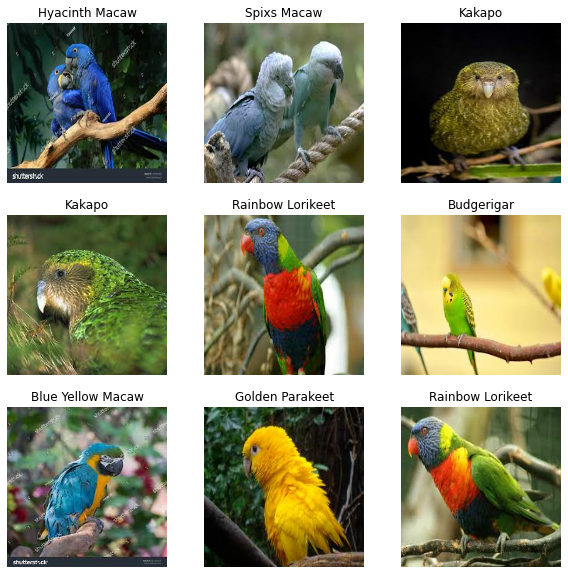

In [47]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

<a name='section3'></a>
# **Data Preprocessing**
---

## Data Augmentation

Keras provides data augmentation layers such as RandomFlip, Rescaling, RandomRotation. We will use Keras **RandomFlip** and **RandomRotation** layers in our transfer learning model.

In [48]:
def data_augmenter():

  random_flip_and_rotation = tf.keras.Sequential([
    tfl.RandomFlip('horizontal'),
    tfl.RandomRotation(0.2)
  ])

  return random_flip_and_rotation


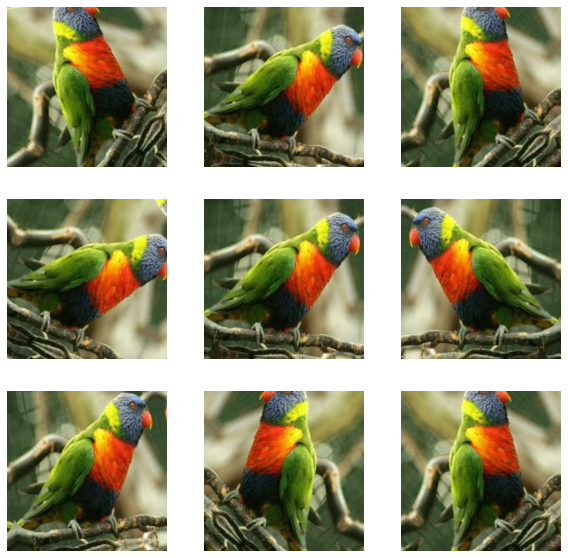

In [49]:
data_augmentation = data_augmenter()

plt.figure(figsize=(10, 10))
image = images[8]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Image Normalization 

* Keras MobileNetV2 model provides **preprocess_input** function for preprocessing input images so that image values are normalized in [-1,1] range.

In [50]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='section4'></a>
# **Model Training**
---

## Creating Tranfer Learning Model

* First load Keras MobileNetV2 model (base model) with ImageNet weights.
* Delete the top layer from base model and include **Softmax** classifier layer.
* Train only one layer freezing the rest of the network.
* Add **GlobalAveragePooling2D** layer to summarize info in each channel
* Add **Dropout** layer to avoid overfitting.

In [51]:
def transfer_learning_model(class_names, image_shape=IMG_SIZE):
    
    input_shape = image_shape + (3,)
        
    # load MobileNetV2 model with ImageNet weight and delete top layer
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights="imagenet") 
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    data_augmentation = data_augmenter()
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)

    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # Add softmax layer with 8 units for categorical classification
    output_layers = len(class_names)
    outputs = tfl.Dense(output_layers, activation = "softmax")(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

## Training Transfer Learning Model

* Learning Rate = 0.001
* Optimization Algo = Adam
* Loss = Categorical Crossentropy
* Epochs = 5

In [52]:
# create model instance
bird_model = transfer_learning_model(train_dataset.class_names,IMG_SIZE)
bird_model.summary()

# parameters
initial_epochs = 5
base_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)

# compile model
bird_model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

# train model on train dataset and validate with validation dataset
history = bird_model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

20/20 [==============================] - 27s 1s/step - loss: 1.7162 - accuracy: 0.4010 - val_loss: 0.8399 - val_accuracy: 0.8506
Epoch 2/5
20/20 [==============================] - 20s 984ms/step - loss: 0.6484 - accuracy: 0.8247 - val_loss: 0.4434 - val_accuracy: 0.9221
Epoch 3/5
20/20 [==============================] - 24s 1s/step - loss: 0.3957 - accuracy: 0.9091 - val_loss: 0.3141 - val_accuracy: 0.9351
Epoch 4/5
20/20 [==============================] - 21s 993ms/step - loss: 0.2725 - accuracy: 0.9399 - val_loss: 0.2533 - val_accuracy: 0.9610
Epoch 5/5
20/20 [==============================] - 20s 982ms/step - loss: 0.2317 - accuracy: 0.9529 - val_loss: 0.2191 - val_accuracy: 0.9481


## Evaluate Model

Evaluate Bird Model with test dataset.

In [53]:
test_history = bird_model.evaluate(test_dataset)

5/5 [==============================] - 3s 482ms/step - loss: 0.3441 - accuracy: 0.8958


* Bird Model achieved 95% train, 94% validation and 89% test accuracy.

In [54]:
train_acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

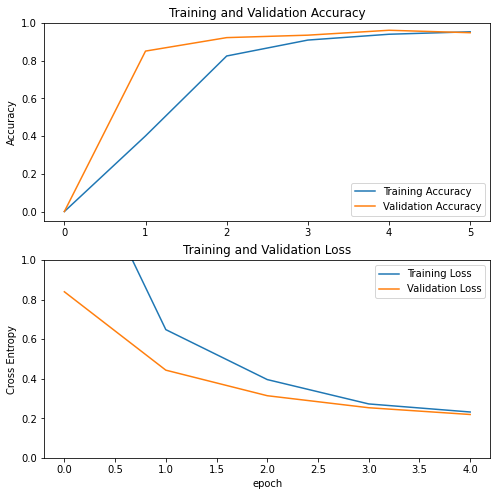

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<a name='section5'></a>
# **Fine-tuning Model**
---

We can fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. 

* Unfreez final 30 layers of MobileNetV2 and retrain with very low learning rate.


In [56]:
# unfreez final 30 layers of MobileNetV2
base_model = bird_model.layers[4]
base_model.trainable = True

fine_tune_at = 120
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
bird_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

* Trainable params: 1,635,144  after unfreezing final 30 layers of MobileNetV2

## Retraining Fine-tuned Model

In [57]:
# parameters
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs
base_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)

# compile fine-tuned model
bird_model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

# retrain model on train dataset and validate with validation dataset
finetuned_history = bird_model.fit(train_dataset,
                                  epochs=total_epochs,
                                  initial_epoch=history.epoch[-1],
                                  validation_data=validation_dataset)

Epoch 5/10


20/20 [==============================] - 34s 1s/step - loss: 0.2692 - accuracy: 0.9075 - val_loss: 0.1424 - val_accuracy: 0.9675
Epoch 6/10
20/20 [==============================] - 28s 1s/step - loss: 0.1068 - accuracy: 0.9675 - val_loss: 0.0740 - val_accuracy: 0.9675
Epoch 7/10
20/20 [==============================] - 32s 2s/step - loss: 0.0857 - accuracy: 0.9708 - val_loss: 0.0673 - val_accuracy: 0.9675
Epoch 8/10
20/20 [==============================] - 33s 2s/step - loss: 0.0582 - accuracy: 0.9821 - val_loss: 0.0571 - val_accuracy: 0.9740
Epoch 9/10
20/20 [==============================] - 29s 1s/step - loss: 0.0703 - accuracy: 0.9756 - val_loss: 0.0595 - val_accuracy: 0.9740
Epoch 10/10
20/20 [==============================] - 28s 1s/step - loss: 0.0518 - accuracy: 0.9821 - val_loss: 0.0952 - val_accuracy: 0.9610


## Evaluate Fine-tuned Model

In [58]:
test_finetuned_history = bird_model.evaluate(test_dataset)

5/5 [==============================] - 3s 502ms/step - loss: 0.1620 - accuracy: 0.9306


* Bird Fine-tuned Model achieved 98% train, 96% validation and 93% test accuracy.

<a name='section6'></a>
# **Model Analysis**

## Train and Validation Accuracy Plot 

* Bird Model train and validation accuracy before and after fine-tuning.

In [60]:
train_acc += finetuned_history.history['accuracy']
val_acc += finetuned_history.history['val_accuracy']

train_loss += finetuned_history.history['loss']
val_loss += finetuned_history.history['val_loss']

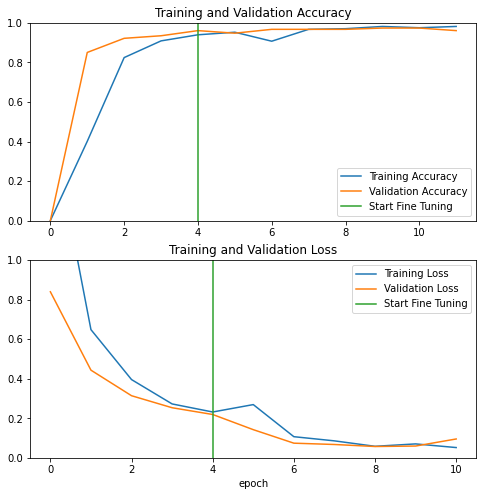

In [61]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Model Comparison

In [86]:
test_loss = [test_history[0]*100,test_finetuned_history[0]*100]
test_accuracy = [test_history[1]*100,test_finetuned_history[1]*100]


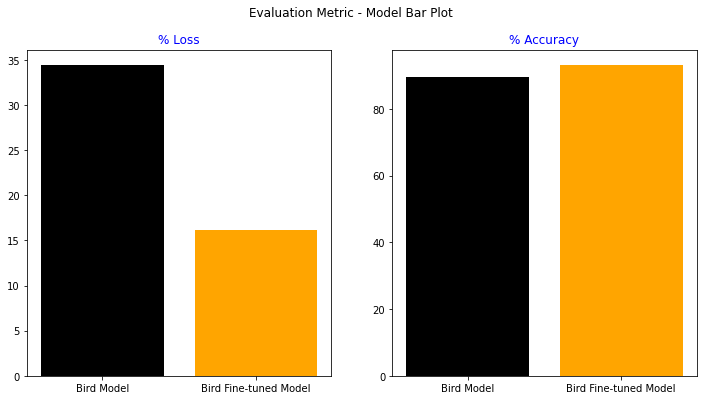

In [91]:
model_list = ['Bird Model', 'Bird Fine-tuned Model']

fig,(ax1,ax2) = plt.subplots(1,2,sharex=True,figsize=(12,6))
fig.suptitle("Evaluation Metric - Model Bar Plot")

ax1.bar(model_list, test_loss, color=('black','orange'),label = model_list)
ax1.set_title('% Loss',color='blue')

ax2.bar(model_list, test_accuracy, color=('black','orange'),label = model_list)
ax2.set_title('% Accuracy',color='blue')

fig.show()

* Bird model accuracy increased from 89% to 93% after fine-tuning and loss decresed 35% to 15% in test dataset.

# **Conclusion**

* Created CNN model to classify 8 different Parrot Species (Dataset from internet) using Keras MobileNetV2 model for Transfer Learning.
* Test Accuracy increased from 89% to 93% after fine-tuning final layers of MobileNetV2 model.